In [502]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz


pd.options.mode.copy_on_write = True

def filter_location(dat: pd.DataFrame,x:list, y:list):
    '''
    Filtra las coordenadas para Antofagasta, excluyendo las otras comunas
    '''
    try: # Alerts
        dat = dat[(dat['location'].apply(lambda loc: loc['x'] >= x[0] and loc['x'] <= x[1] ))]
        dat = dat[(dat['location'].apply(lambda loc: loc['y'] >= y[0] and loc['y'] <= y[1] ))]
    except KeyError: # Jam
        dat = dat[(dat['line'].apply(lambda line: line[0]['x'] >= x[0] and line[0]['x'] <= x[1]))]
        dat = dat[(dat['line'].apply(lambda line: line[0]['y'] >= y[0] and line[0]['y'] <= y[1]))]

    return dat

def haversine(coordx, coordy):
    lon1, lon2 = coordx
    lat1, lat2 = coordy

    # Convertir coordenadas de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferencias de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.asin(np.sqrt(a))

    # Radio de la Tierra en kilómetros
    r = 6371

    # Distancia en metros
    return c * r * 1000

def nearby(row, df):
    NEARBY_METERS = 200
    c = 0
    for i in df.index:
        c += 1 if row.geometry.distance(df.loc[i, 'geometry']) <= NEARBY_METERS else 0
    return c

URL_DATA = "antofTraffic/data.json"

with open(URL_DATA, "r") as f:
    data = json.load(f)
    f.close()

alerts = pd.DataFrame(data['alerts'])
jams = pd.DataFrame(data['jams'])

PERIM_X = [-70.45534224747098, -70.32743722434367]
PERIM_Y = [-23.701724880116387, -23.411242421131792]


alerts = filter_location(alerts, PERIM_X, PERIM_Y)
jams = filter_location(jams, PERIM_X, PERIM_Y)


In [503]:
alerts['x'] = alerts['location'].apply(lambda x: x['x'])
alerts['y'] = alerts['location'].apply(lambda y: y['y'])
alerts = alerts.drop(columns="location")

X_BOUND = [alerts.x.min(), alerts.x.max()]
Y_BOUND = [alerts.y.min(), alerts.y.max()]

Sistema de referencia EPSG estándar para manipulación de datos espaciales en plano web: EPSG:4326 (WGS 84)


Además para mapas en línea se utiliza EPSG:3857 (Pseudo-Mercator), lo que incluye a contextily

In [504]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx

alerts['geometry'] = alerts.apply(lambda row: Point(row['x'], row['y']), axis=1)
alerts_antof = gpd.GeoDataFrame(alerts, geometry='geometry')
alerts_antof = alerts_antof.set_crs(epsg=4326)
alerts_antof = alerts_antof.to_crs(epsg=3857) # Adecuado para visualización en plano
alerts_antof.head()

,country,city,reportRating,reportByMunicipalityUser,confidence,reliability,type,uuid,roadType,magvar,subtype,street,pubMillis,endreport,x,y,geometry
0,CI,Antofagasta,1,false,5,10,HAZARD,a123f22e-e5e0-4c6c-8a4e-7434c4fd2110,6,17,HAZARD_ON_ROAD_CONSTRUCTION,Av. República de Croacia,1724417637000,1.724425e+12,-70.412429,-23.676846,POINT (-7838275.742 -2714079.538)
1,CI,Antofagasta,0,false,0,5,JAM,1d8df954-e380-4327-8015-f4fbadf74f2d,6,4,JAM_HEAVY_TRAFFIC,Av. Edmundo Pérez Zujovic,1724423878000,1.724425e+12,-70.392283,-23.617475,POINT (-7836033.099 -2706864.568)
2,CI,Antofagasta,0,false,0,5,JAM,c53a5bc6-f6b6-44b8-a5bd-af69b60a4580,1,359,,Pasaje El Volcán,1724425406000,1.724425e+12,-70.385619,-23.573323,POINT (-7835291.266 -2701501.184)
3,CI,Antofagasta,1,false,0,5,JAM,53b6ff5f-d078-421d-9f78-03e534d78989,2,1,,Azapa,1724425622000,1.724425e+12,-70.384986,-23.616328,POINT (-7835220.801 -2706725.213)
4,CI,Antofagasta,2,false,0,5,ACCIDENT,e87552f7-4572-4096-9fdd-9400ad90e7f8,2,281,,Irarrázaval,1724425939000,1.724425e+12,-70.385121,-23.603942,POINT (-7835235.829 -2705220.449)


In [505]:
alerts_antof.head()

,country,city,reportRating,reportByMunicipalityUser,confidence,reliability,type,uuid,roadType,magvar,subtype,street,pubMillis,endreport,x,y,geometry
0,CI,Antofagasta,1,false,5,10,HAZARD,a123f22e-e5e0-4c6c-8a4e-7434c4fd2110,6,17,HAZARD_ON_ROAD_CONSTRUCTION,Av. República de Croacia,1724417637000,1.724425e+12,-70.412429,-23.676846,POINT (-7838275.742 -2714079.538)
1,CI,Antofagasta,0,false,0,5,JAM,1d8df954-e380-4327-8015-f4fbadf74f2d,6,4,JAM_HEAVY_TRAFFIC,Av. Edmundo Pérez Zujovic,1724423878000,1.724425e+12,-70.392283,-23.617475,POINT (-7836033.099 -2706864.568)
2,CI,Antofagasta,0,false,0,5,JAM,c53a5bc6-f6b6-44b8-a5bd-af69b60a4580,1,359,,Pasaje El Volcán,1724425406000,1.724425e+12,-70.385619,-23.573323,POINT (-7835291.266 -2701501.184)
3,CI,Antofagasta,1,false,0,5,JAM,53b6ff5f-d078-421d-9f78-03e534d78989,2,1,,Azapa,1724425622000,1.724425e+12,-70.384986,-23.616328,POINT (-7835220.801 -2706725.213)
4,CI,Antofagasta,2,false,0,5,ACCIDENT,e87552f7-4572-4096-9fdd-9400ad90e7f8,2,281,,Irarrázaval,1724425939000,1.724425e+12,-70.385121,-23.603942,POINT (-7835235.829 -2705220.449)


In [506]:
alerts_antof['type'].unique()

array(['HAZARD', 'JAM', 'ACCIDENT', 'ROAD_CLOSED'], dtype=object)

In [507]:
def heat_map(concept:str):

    concepts = {
        'ACCIDENT': 'Accidentes reportados',
        'HAZARD': 'Peligros reportados',
        'JAM': 'Congestión de tráfico reportada'
    }

    event = alerts_antof[alerts_antof['type'] == concept]
    event = event[['geometry']]
    
    event = event.to_crs(epsg=32619) # Adecuado para mediciones en metros
    event['freq'] = event.apply(lambda row: nearby(row, event), axis=1)
    event = event.to_crs(epsg=3857) # Para visualización correcta en plano

    fig, ax = plt.subplots()
    fig.set_size_inches((4.5, 9.5))
    sc = event['geometry'].plot(ax=ax, alpha=0.5, c=event['freq'], cmap='GnBu')
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, alpha=0.6)
    # Añadir la barra de colores
    cbar = sc.get_figure().colorbar(sc.collections[0], ax=ax)
    cbar.set_label('Frecuencia')
    ax.set_xlabel('Latitud')
    ax.set_ylabel('Longitud')
    plt.xticks(rotation=45)
    plt.title(f'{concepts[concept]}\n Antofagasta', fontweight='bold')
    plt.savefig(f'graph/{concept}_freq_map.png')
    plt.show()



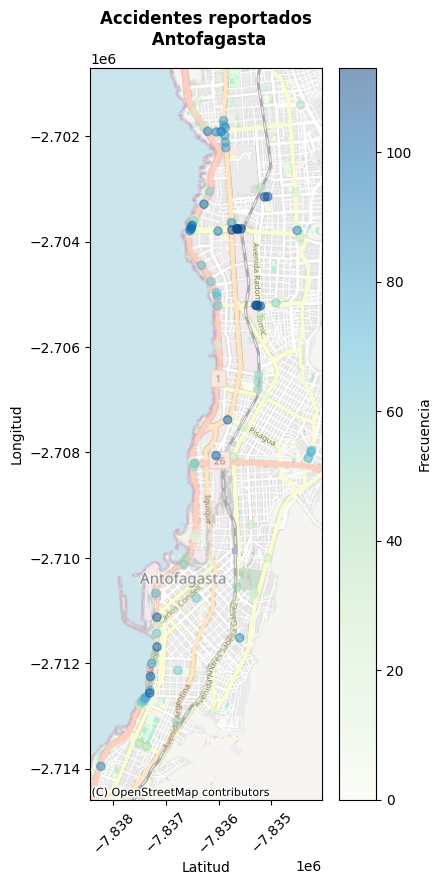

In [508]:
heat_map('ACCIDENT')

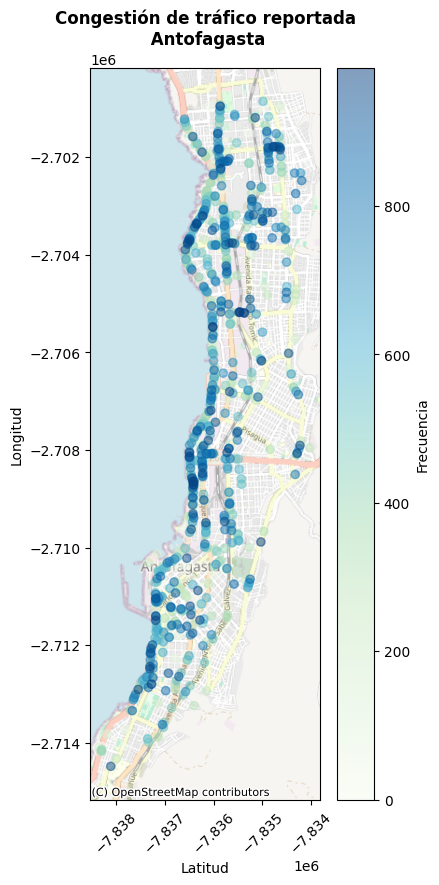

In [509]:
heat_map('JAM')

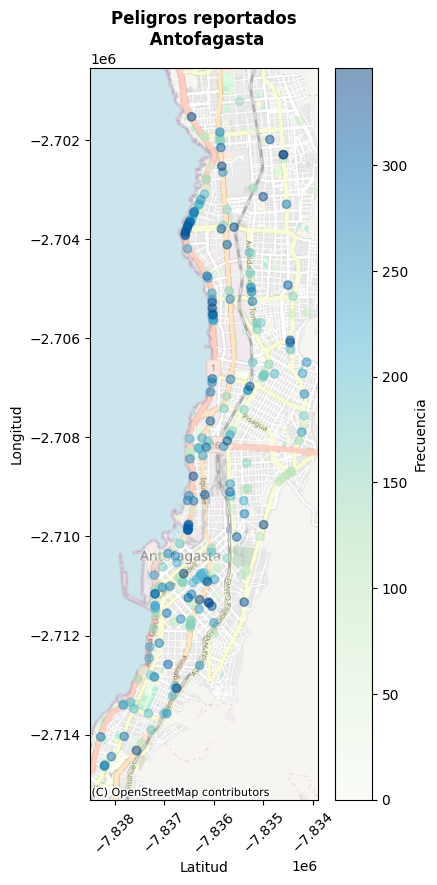

In [510]:
heat_map('HAZARD')

In [511]:
def extract_event(data:gpd.GeoDataFrame, concept:str):
    dat = data[data['type'] == concept][['roadType', 'street', 'pubMillis', 'endreport', 'geometry']]

    dat['pubMillis'] = pd.to_datetime(data['pubMillis'], unit='ms', utc=True)

    # Convertir la marca de tiempo a la zona horaria GMT-4 (CLT - Chile Standard Time)
    dat['pubMillis'] = dat['pubMillis'].dt.tz_convert('America/Santiago')
    
    # Ya se encuentra en GMT-4
    dat['endreports'] = pd.to_datetime(data['endreport'], unit='ms')
    
    dat = dat.rename(columns={'pubMillis': 'inicio', 'endreport':'fin'})
    dat['hour'] = dat['inicio'].dt.hour
    dat['day'] = dat['inicio'].dt.dayofweek
    dat['day_type'] = dat['day'].apply(lambda x: 'Semana' if x < 5 else 'Fin de semana')    
    return dat

In [512]:

accident = extract_event(alerts_antof, 'ACCIDENT')
jam = extract_event(alerts_antof, 'JAM')
hazard = extract_event(alerts_antof, 'HAZARD')

In [513]:
def day_report(data:gpd.GeoDataFrame, concept:str):
    concepts = {
        'ACCIDENT': 'Accidentes reportados',
        'HAZARD': 'Peligros reportados',
        'JAM': 'Congestión de tráfico reportada'
    }
    # Agrupar por hora y tipo de día
    hourly_reports = data.groupby(['day_type', 'hour']).size().unstack(level=0)

        # Crear un índice que incluya todas las horas del día
    all_hours = pd.Index(range(24), name='hour')

    # Reindexar el DataFrame para incluir todas las horas del día
    hourly_reports = hourly_reports.reindex(all_hours, fill_value=0)

    # Graficar la fluctuación de reportes por hora diferenciando entre semana y fin de semana
    plt.figure(figsize=(10, 6))

    # Ajustar las posiciones de las barras
    bar_width = 0.4
    r1 = np.arange(len(hourly_reports))
    r2 = [x + bar_width for x in r1]

    plt.bar(r1, hourly_reports['Semana'], color='salmon', width=bar_width, edgecolor='grey', label='Semana')
    plt.bar(r2, hourly_reports['Fin de semana'], color='skyblue', width=bar_width, edgecolor='grey', label='Fin de Semana')

    plt.title(f'{concepts[concept]} durante el día \n (Semana vs. Fin de Semana)')
    plt.xlabel('Hora del día')
    plt.ylabel('Número de reportes')
    
    plt.xticks([r + bar_width / 2 for r in range(len(hourly_reports))], hourly_reports.index)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.savefig(f'graph/{concept}_per_hour.png')
    plt.show()

    return hourly_reports

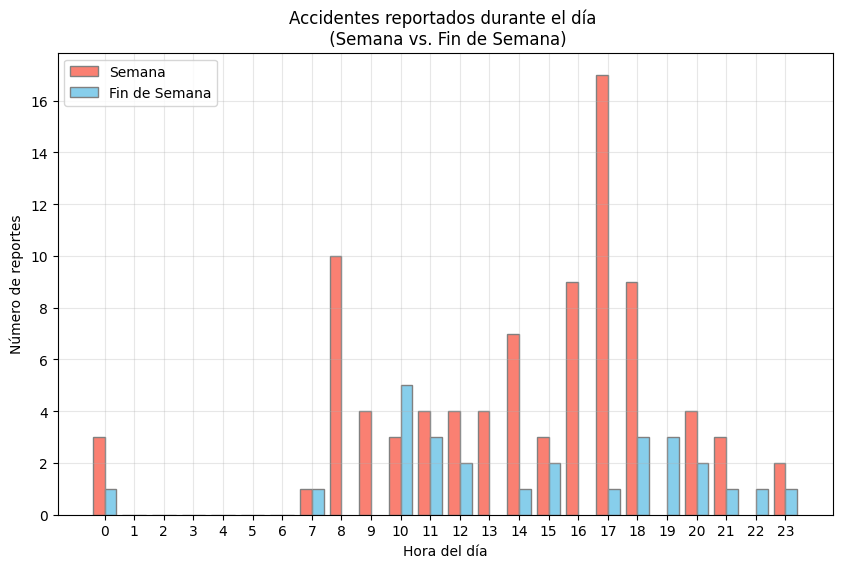

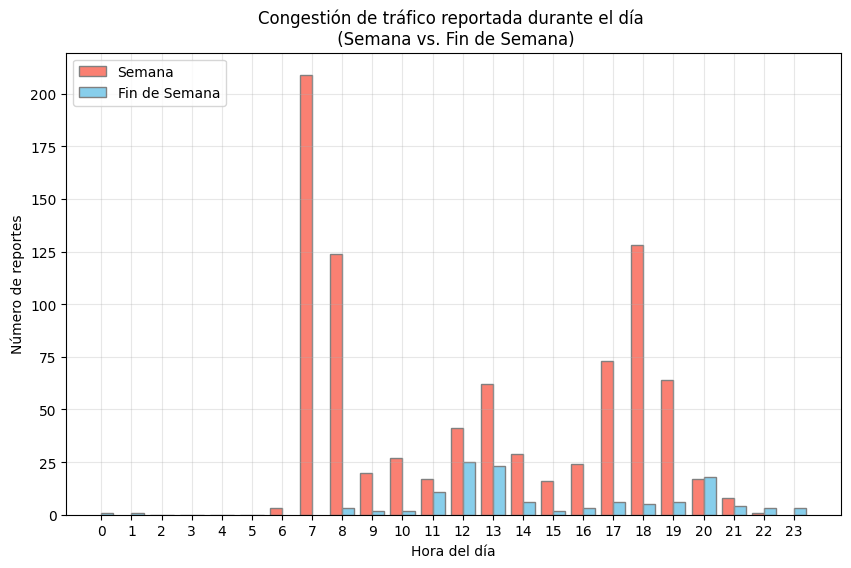

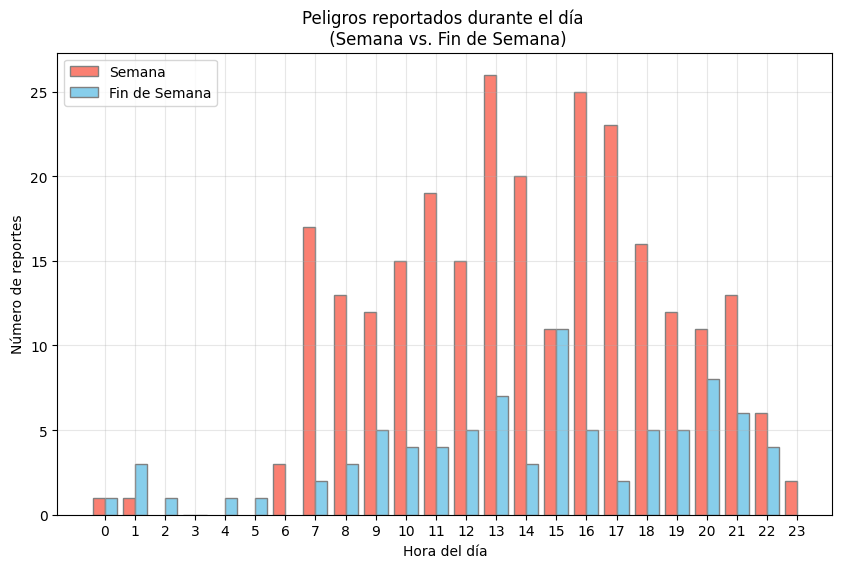

In [514]:
hourly_accident = day_report(accident, 'ACCIDENT')
hourly_jam = day_report(jam, 'JAM')
hourly_hazard = day_report(hazard, 'HAZARD')

In [587]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linear_model = LinearRegression()

# Join the three DataFrames on the 'hour' index
dat = hourly_accident.join(hourly_jam, lsuffix='_accident', rsuffix='_jam').join(hourly_hazard, rsuffix='_hazard')

dat = dat[['Semana_accident', 'Semana']]

# Fill missing values with 0
dat = dat.fillna(0)

# Create the feature matrix X
X = dat[['Semana']].values

# Create the target vector y
y = dat['Semana_accident'].values

y = hourly_accident.Semana.fillna(0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

y_pred


array([6.75880193, 5.36892505, 2.24170207, 7.10627115, 3.97904817])

In [588]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print(f'Coeficiente de determinación: {r2_score(y_test, y_pred)}')
print(f'Error cuadrático medio: {mean_squared_error(y_test, y_pred)}')


Coeficiente de determinación: 0.2754065609699696
Error cuadrático medio: 3.6519509327113533


In [589]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linear_model, X, y, cv=5)
print(f"R^2 scores: {scores}")

R^2 scores: [-0.54622298  0.23582357 -7.71105819 -0.0308387   0.08659218]


In [590]:
import statsmodels.formula.api as smf

# Crear un DataFrame con los datos de entrenamiento
linear_model = smf.ols(data=dat, formula='Semana_accident ~ Semana')
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Semana_accident   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     18.64
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           0.000277
Time:                        03:14:13   Log-Likelihood:                -60.617
No. Observations:                  24   AIC:                             125.2
Df Residuals:                      22   BIC:                             127.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0087      1.060     -0.008      0.9

In [591]:
results.params

Intercept   -0.008700
Semana       0.334133
dtype: float64

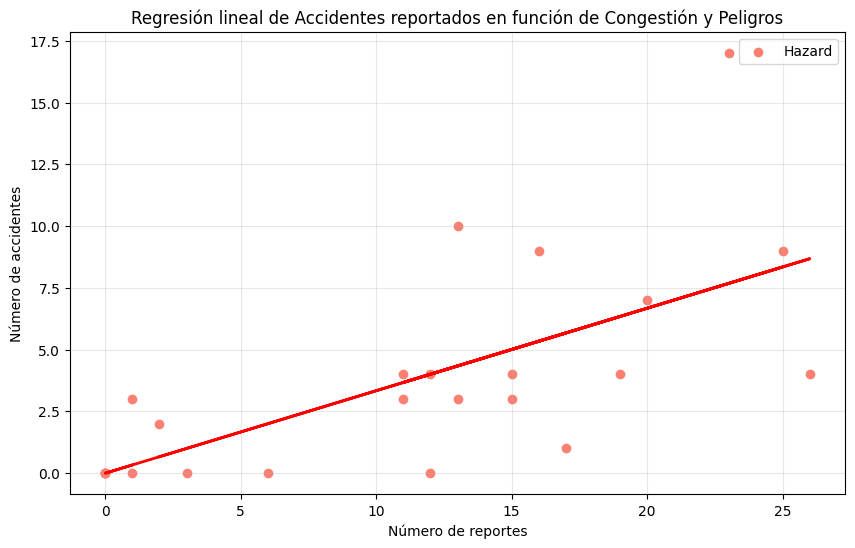

In [592]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.scatter(dat['Semana'], dat['Semana_accident'], color='salmon', label='Hazard')

# Graficar la línea de regresión
plt.plot(dat['Semana'], results.params['Intercept'] + results.params['Semana'] * dat['Semana'], color='red', linewidth=2)

plt.title('Regresión lineal de Accidentes reportados en función de Congestión y Peligros')
plt.xlabel('Número de reportes')
plt.ylabel('Número de accidentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()